### Vandermonde With Arnoldi

This is a small notebook replicating some of the results of the paper "VANDERMONDE WITH ARNOLDI" by Brubeck, Nakatksukasa, and Trefethen

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.

In [1]:
using PyPlot

So interpolating in the Chebyshev points is well conditioned.  Just using that with the Vandermonde matrix is a big step up from the completely unusable evenly spaced grid, but it is not perfect, as the following shows.

In [2]:
function chebpts(n)
    m = n - 1
    x = sinpi.([-m:2:m;] ./ 2m)
    return x
end;

function chebpts(n::Int, l::Float64, u::Float64)
    x = chebpts(n) * ((u - l) / 2.0)
    s = l - x[1]
    return x .+ s
end;

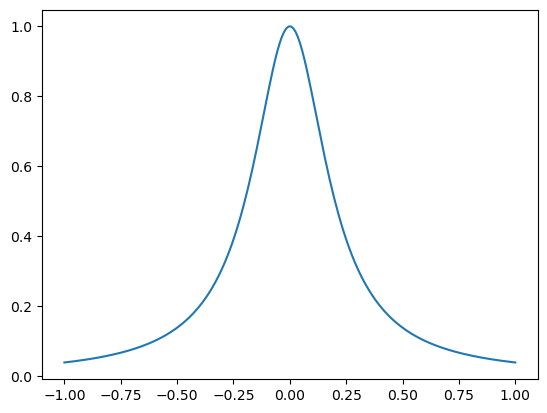

In [3]:
runge(x) = 1.0 / (1.0 + 25.0 * x^2)
xx = range(-1, 1, length=200)
yy = runge.(xx)
plot(xx, yy);

In [4]:
function vander(x::AbstractVector{T}, m=length(x)) where {T}
    n = length(x)
    v = Array{T}(undef, n, m)
    if m > 0
        v[:, 1] .= ones(T, n)
        if m > 1
            v[:, 2] .= x
            @inbounds @views for i in 3:m
                v[:, i] .= v[:, i - 1] .* x
            end
        end
    end
    return v
end

# This is essentially what the Trefethen paper uses for calculating
# the Vandermonde matrix.  This is numerically not as good as the previous
# method (higher condition number for the generated matrix).  Also, for
# large matrices it can be a _lot_ slower.  But if you are taking Vandermonde
# matrices of large vectors, you are probably doing something wrong.
function dumb_vander(x::AbstractVector{T}, m=length(x)) where {T}
    reduce(hcat, (x .^ i for i in 0:m-1))
end

function polyfit(x::AbstractVector{T}, f::AbstractVector{T}, n) where{T}
    A = vander(x, n)
    c = A \ f
end


function polyval(c, s)
    B = vander(s, length(c))
    y = B * c
end;

In [5]:
n = 80
s = chebpts(n+1)
y = runge.(s)
c = polyfit(s, y, n);

Max error: 0.00030796699722712706

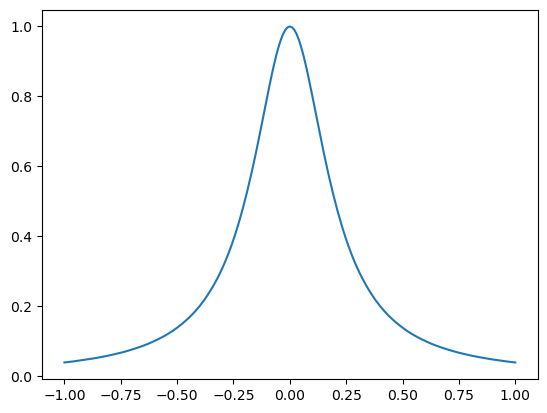

In [6]:
xx = [-1.0:0.01:1.0;]
yy = polyval(c, xx)
err = maximum(abs.(yy - runge.(xx)))
println("Max error: ", err)
plot(xx, yy);

By eye, it doesn't look too bad, but the error still appears big.  Let's see how that changes with number of interpolation points.

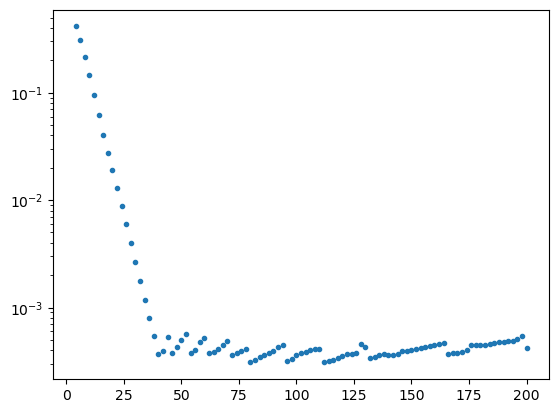

In [7]:
xx = [-1.0:0.001:1.0;]
ytrue = runge.(xx)
iters = Int[]
errors = Float64[]
for n in 4:2:200
    s = chebpts(n+1)
    y = runge.(s)
    c = polyfit(s, y, n)
    yy = polyval(c, xx)
    err = maximum(abs.(yy - ytrue))
    push!(iters, n)
    push!(errors, err)
end
semilogy(iters, errors, ".");

So it stagnates at somewhere around 40 Chebyshev interpolation points, which is what is shown in the Trefethen paper.

Here are the analogous Vandermonde with Arnoldi (Vandernoldi?) functions from the paper translated to Julia.

In [8]:
function polyfitA(x::S, f::S, n) where {T, S <: AbstractVector{T}}
    m = length(x)
    H = zeros(T, n+1, n)
    Q = Array{T, 2}(undef, m, n + 1)
    Q[:, 1] .= one(T)
    @inbounds @views for k = 1:n
        q = x .* Q[:, k]
        for j = 1:k
            H[j, k] = Q[:, j]' * q/m
            q = q - H[j, k] * Q[:, j]
        end
        H[k+1, k] = norm(q) / sqrt(m)
        Q[:, k+1] = q / H[k+1, k]
    end
    d = Q \ f
    return (d, H)
end

function polyvalA(d::S, H::U, s::S) where {T, S <: AbstractVector{T}, U <: AbstractMatrix{T}}
    m = length(s)
    n = size(H, 2)
    W = Array{T, 2}(undef, m, n + 1)
    W[:, 1] .= one(T)
    
    @inbounds @views for k = 1:n
        w = s .* W[:, k]
        for j = 1:k
            w = w - H[j, k] * W[:, j]
        end
        W[:, k+1] = w / H[k+1,k]
    end
    return W * d
end;

And the corresponding errors:

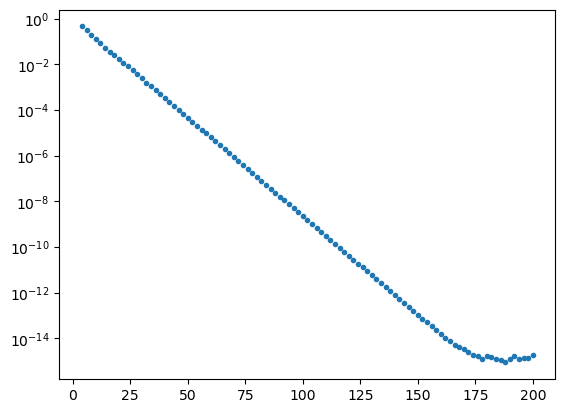

In [9]:
iters = Int[]
errors = Float64[]
for n in 4:2:200
    s = chebpts(n+1)
    y = runge.(s)
    d, H = polyfitA(s, y, n)
    yy = polyvalA(d, H, xx)
    err = maximum(abs.(yy - ytrue))
    push!(iters, n)
    push!(errors, err)
end
semilogy(iters, errors, ".");

Again, this is pretty close to what is shown in the paper.

Section 3 of the paper does a least squares approximation of sign(x) on the interval 
[-1, -1/3] U [1/3, 1].

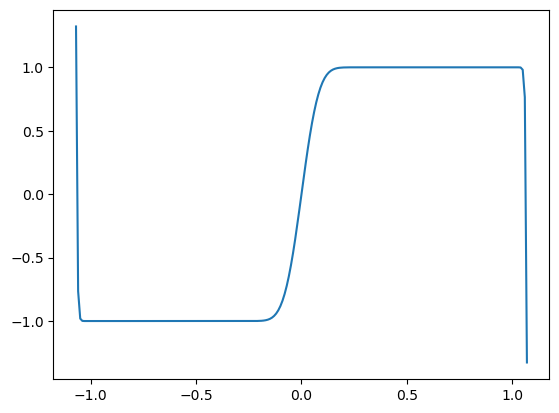

In [10]:
xx = [-1.07:0.01:1.07;]
ytrue = sign.(xx)
funky_points(n) = [chebpts(n, -1.0, -1/3); chebpts(n, 1/3, 1.0)]
n =  80
s = funky_points(n)
y = sign.(s)
d, H = polyfitA(s, y, n)
yy = polyvalA(d, H, xx)
plot(xx, yy);

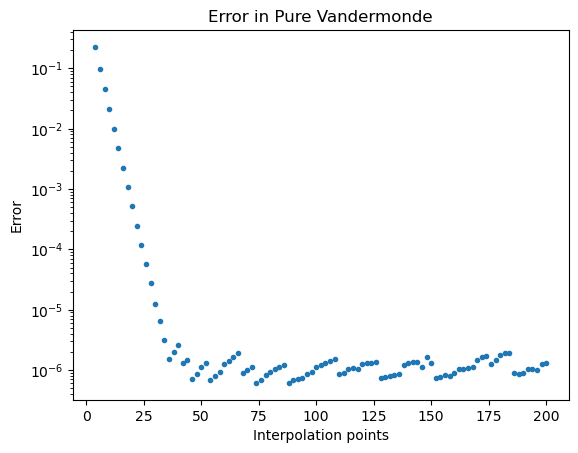

In [11]:
xx = [-1.0:0.01:-1/3; 1/3:0.01:1.0;]
ytrue = sign.(xx)
iters = Int[]
errors = Float64[]
errorsA = Float64[]
for n in 4:2:200
    s = funky_points(n+1)
    y = sign.(s)
    c = polyfit(s, y, n)
    yy = polyval(c, xx)
    err = maximum(abs.(yy - ytrue))
    d, H = polyfitA(s, y, n)
    yyA = polyvalA(d, H, xx)
    errA = maximum(abs.(yyA - ytrue))
    push!(iters, n)
    push!(errorsA, errA)
    push!(errors, err)
end
semilogy(iters, errors, ".")
title("Error in Pure Vandermonde")
xlabel("Interpolation points")
ylabel("Error");

Which is again consistent with the paper, and for the Vandermonde + Arnoldi we have

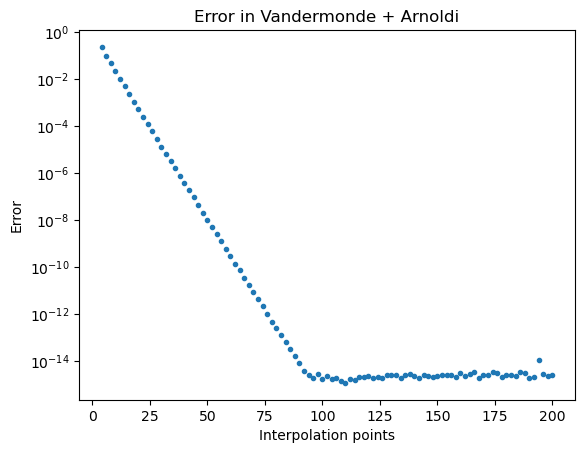

In [12]:
semilogy(iters, errorsA, ".")
title("Error in Vandermonde + Arnoldi")
xlabel("Interpolation points")
ylabel("Error");